# Libraries and Settings

In [235]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm

# Import Data

In [236]:
raw = pd.read_csv('../data/Zip_Zri_AllHomesPlusMultifamily.csv')
raw.columns = raw.columns.str.replace('RegionName', 'zip')

In [237]:
region = raw.iloc[:,:7].set_index('zip')

In [238]:
region

,RegionID,City,State,Metro,CountyName,SizeRank
zip,,,,,,
10025,61639,New York,NY,New York-Newark-Jersey City,New York County,1
60657,84654,Chicago,IL,Chicago-Naperville-Elgin,Cook County,2
10023,61637,New York,NY,New York-Newark-Jersey City,New York County,3
77494,91982,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,4
60614,84616,Chicago,IL,Chicago-Naperville-Elgin,Cook County,5
...,...,...,...,...,...,...
26291,68966,Snowshoe,WV,NaN,Pocahontas County,13177
12720,62697,Bethel,NY,NaN,Sullivan County,13178
26209,68924,Snowshoe,WV,NaN,Pocahontas County,13179


In [239]:
data = pd.concat([raw['zip'],raw.iloc[:,11:-1]],axis=1).set_index('zip')

# Data Cleaning

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

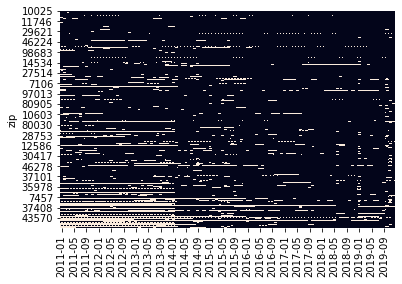

In [6]:
sns.heatmap(data.isnull(), cbar=False)

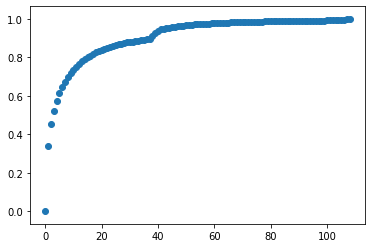

In [7]:
missingness = [np.mean(data.isna().sum(axis=1) < i) for i in range(12*9+1)]
plt.scatter(range(12*9+1),missingness)

In [8]:
data = data[data.isna().sum(axis=1) < 20]

In [311]:
data.shape

(13181, 108)

# Time Series Analysis for a Single Zip Code

## ZRI vs Time

Text(0.5, 1.0, 'New York, 10006')

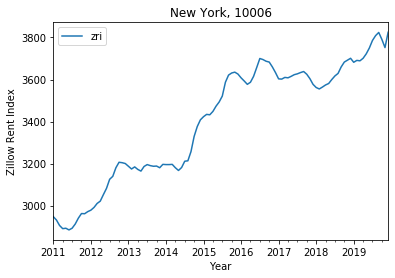

In [315]:
zip_number = 10006
zipcode = data.loc[data.index==zip_number,:].T
zipcode.index = pd.to_datetime(zipcode.index)
zipcode.columns = ['zri']
zipcode.plot()
plt.xlabel('Year')
plt.ylabel('Zillow Rent Index')
plt.title('New York, 10006')

## Monthly Trend

Text(0.5, 1.0, 'New York, 10006')

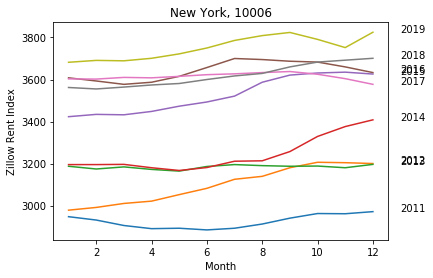

In [316]:
zipcode['year'] = zipcode.index.year
zipcode['month'] = zipcode.index.month
for y in range(2011,2020):
    plt.plot('month','zri',data = zipcode.loc[zipcode['year'] == y,:])
    plt.text(zipcode.loc[zipcode.year==y, :].shape[0]+1, zipcode.loc[zipcode.year==y, 'zri'][-1:].values[0], y)
plt.xlabel('Month')
plt.ylabel('Zillow Rent Index')
plt.title('New York, 10006')

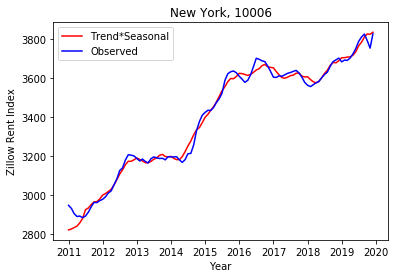

In [317]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(zipcode['zri'], model='multiplicative', extrapolate_trend='freq')
plt.plot(decomp.trend*decomp.seasonal,color='r',label='Trend*Seasonal')
plt.plot(zipcode['zri'],color='b',label='Observed')
plt.xlabel('Year')
plt.ylabel('Zillow Rent Index')
plt.title('New York, 10006')
plt.legend()

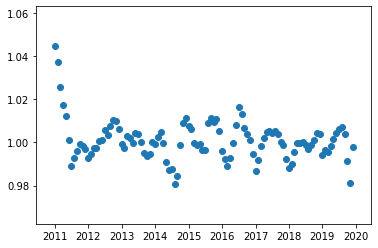

In [318]:
plt.scatter(decomp.resid.index,decomp.resid);

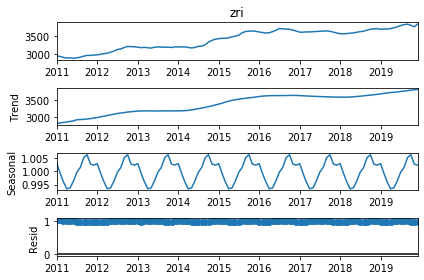

In [319]:
decomp.plot();

## Order of Differencing

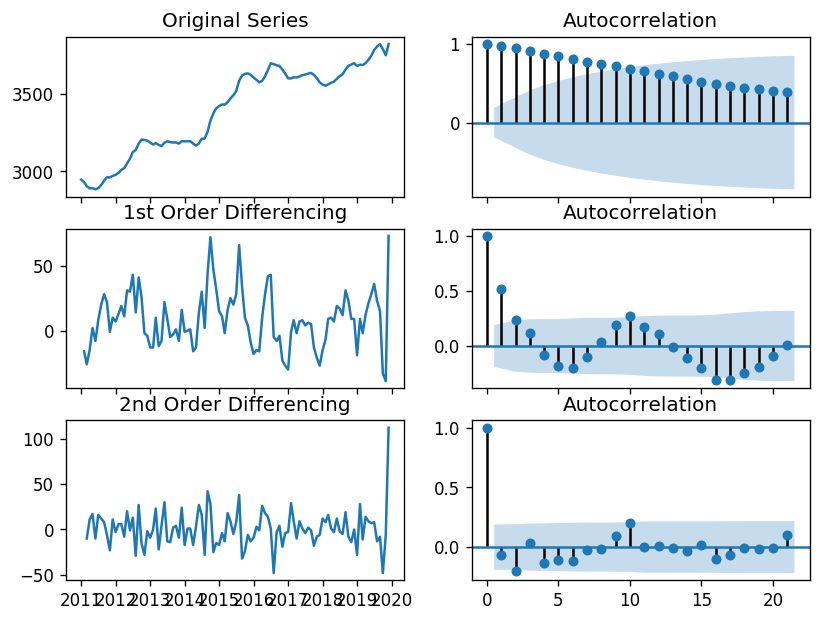

In [322]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(8,6), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2,sharex='col')
axes[0, 0].plot(zipcode['zri']); axes[0, 0].set_title('Original Series')
plot_acf(zipcode['zri'], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(zipcode['zri'].diff().dropna()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(zipcode['zri'].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(zipcode['zri'].diff().diff().dropna()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(zipcode['zri'].diff().diff().dropna(), ax=axes[2, 1]);

##  Order of the AR Term

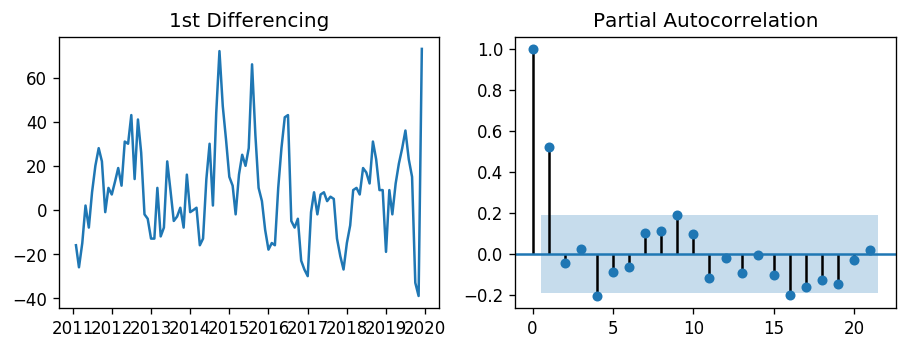

In [323]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(zipcode['zri'].diff()); axes[0].set_title('1st Differencing')
plot_pacf(zipcode['zri'].diff().dropna(), ax=axes[1]);

## Seasonal Autoregression Model

In [333]:
train_zip = zipcode['2011':'2018']
test_zip = zipcode['2019']

In [336]:
mod = sm.tsa.statespace.SARIMAX(train_zip['zri'], order=(1,1,0), seasonal_order=(1,1,0,12),freq='MS')
%time fitted = mod.fit(disp=False)
# print(res.summary())
print(res.arparams[0])
print(res.seasonalarparams[0])
print(res.pvalues[:2])

CPU times: user 239 ms, sys: 24.9 ms, total: 264 ms
Wall time: 165 ms
0.696552377491518
-0.529192314129369
ar.L1       4.462620e-14
ar.S.L12    1.107229e-09
dtype: float64


In [373]:
conf

,lower zri,upper zri
2019-01-01,3668.482028,3737.793974
2019-02-01,3648.530517,3785.029128
2019-03-01,3635.559944,3839.274214
2019-04-01,3615.376930,3883.705750
2019-05-01,3597.773005,3927.115637
2019-06-01,3586.471795,3972.998088
2019-07-01,3572.716827,4012.722134
2019-08-01,3558.510800,4048.567760
2019-09-01,3553.665141,4090.674597
2019-10-01,3536.490636,4117.683100


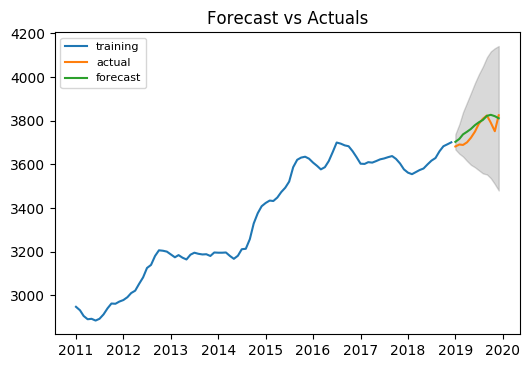

In [403]:

# Forecast
fc = fitted.forecast(test_zip['zri'].shape[0])
pred = fitted.get_prediction(start='2019-01',end='2019-12')
conf = pred.conf_int()# 95% conf

lower_series = conf.iloc[:, 0]
upper_series = conf.iloc[:, 1]
plt.figure(figsize=(6,4), dpi=100)
plt.plot(train_zip['zri'], label='training')
plt.plot(test_zip['zri'], label='actual')
plt.plot(fc, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [391]:
tss = np.sum((test_zip['zri']-test_zip['zri'].mean())**2)
rss = np.sum((test_zip['zri']-fc)**2)
1-rss/tss

0.5498463893502874

In [396]:
(tss/test_zip['zri'].shape[0])**0.5

52.06859791552763

# Train/Test Split

In [9]:
train = data.iloc[:,:-12]
test = data.iloc[:,-12:]

# Impute

In [10]:
train = train.interpolate(method='linear',limit_direction='both', axis=1)
test = test.interpolate(method='linear',limit_direction='both', axis=1)

# Build a Time Series Model for Each Zip Code

In [91]:
# one = train.iloc[0,:]
# mod = sm.tsa.statespace.SARIMAX(one, order=(1,1,0), seasonal_order=(1,1,0,12),freq='MS')
# %time res = mod.fit(disp=False)
# # print(res.summary())
# print(res.arparams[0])
# print(res.seasonalarparams[0])
# print(res.pvalues[:2])

In [67]:
stat = pd.DataFrame(np.zeros(shape=(train.shape[0],4)),index=train.index,columns=['ar','p(ar)','s','p(s)'])
predict = pd.DataFrame(np.zeros(shape=(train.shape[0],12)),index=train.index,columns=[str(i) for i in range(1,13)])

In [161]:
# About 40 minutes
import warnings
warnings.filterwarnings('ignore')
nzip = train.shape[0]
for i in range(nzip):
    one = train.iloc[i,:]
    mod = sm.tsa.statespace.SARIMAX(one, order=(1,1,0), seasonal_order=(1,1,0,12),freq='MS')
    res = mod.fit(disp=False)
    stat.iloc[i,:] = [res.arparams[0],res.pvalues[0],res.seasonalarparams[0],res.pvalues[1]]
    predict.iloc[i,:] = res.predict('2019-01','2019-12').to_list()
#     print(i,' out of ', nzip)
#     print(stat.iloc[i,:])
#     print(predict.iloc[i,:])

## Percentage Errors

In [174]:
pe = pd.DataFrame(np.zeros(shape=(train.shape[0],1)),index=train.index,columns=['Percentage Error'])
for i in range(nzip):
    testone = test.iloc[i,:].to_numpy()
    predictone = predict.iloc[i,:].to_numpy()
    pe.iloc[i,:] = np.sum(abs(predictone-testone)/testone)/12.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x144dba3d0>]],
      dtype=object)

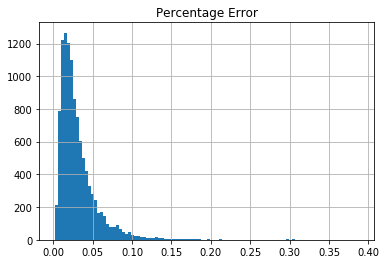

In [175]:
pe.hist(bins=100)

In [176]:
np.mean(pe)

Percentage Error    0.031226
dtype: float64

## Distribution of Coefficients

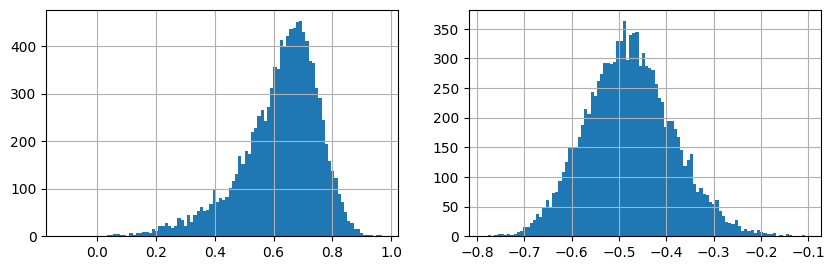

In [164]:
fig, axes = plt.subplots(1, 2, figsize=(10,3), dpi=100)
stat['ar'].hist(bins=100,ax=axes[0])
stat['s'].hist(bins=100,ax=axes[1])

## Residuals

Text(0.5, 1.0, 'Seasonal Autoregression')

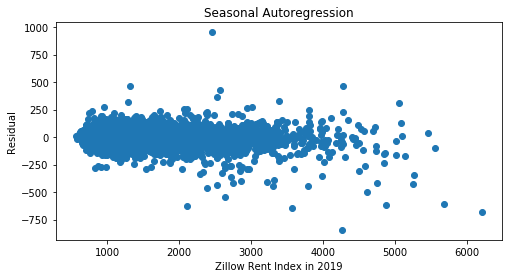

In [184]:
plt.figure(figsize=(8,4))
plt.scatter(test.mean(axis=1),predict.mean(axis=1)-test.mean(axis=1))
plt.xlabel('Zillow Rent Index in 2019')
plt.ylabel('Residual')
plt.title('Seasonal Autoregression')

Text(0.5, 1.0, 'Seasonal Autoregression')

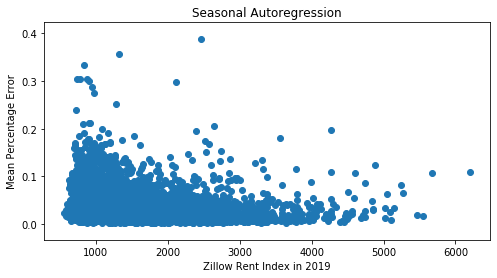

In [201]:
plt.figure(figsize=(8,4))
plt.scatter(test.mean(axis=1),pe)
plt.xlabel('Zillow Rent Index in 2019')
plt.ylabel('Mean Percentage Error')
plt.title('Seasonal Autoregression')

In [401]:
fc

2019-01-01    3703.138001
2019-02-01    3716.779822
2019-03-01    3737.417079
2019-04-01    3749.541340
2019-05-01    3762.444321
2019-06-01    3779.734941
2019-07-01    3792.719481
2019-08-01    3803.539280
2019-09-01    3822.169869
2019-10-01    3827.086868
2019-11-01    3820.885307
2019-12-01    3811.304005
Freq: MS, dtype: float64

In [402]:
tss = np.sum((test.mean(axis=1)-test.mean(axis=1).mean())**2)
rss = np.sum((test.mean(axis=1)-predict.mean(axis=1))**2)
1-rss/tss

AttributeError: 'PredictionResults' object has no attribute 'mean'

In [390]:
(tss/test_zip['zri'].shape[0])**0.5

14645.147517674199

## Outliers

In [208]:
res = pd.concat([test.mean(axis=1),predict.mean(axis=1),pe],axis=1)
res.columns = ['ZRI','Predict','Percentage Error']

In [213]:
outlier = pe['Percentage Error'] > 0.2

In [214]:
region.merge(res[outlier],on='zip').sort_values('Percentage Error')

,RegionID,City,State,Metro,CountyName,SizeRank,ZRI,Predict,Percentage Error
zip,,,,,,,,,
7738,60784,Middletown Township,NJ,New York-Newark-Jersey City,Monmouth County,10634,2639.750000,2094.778005,0.206001
66064,87076,Osawatomie,KS,Kansas City,Miami County,10786,819.833333,991.145812,0.209110
27557,69410,Middlesex,NC,Rocky Mount,Nash County,9502,906.083333,1098.555957,0.212178
49097,79583,Vicksburg,MI,Kalamazoo-Portage,Kalamazoo County,8277,924.000000,1117.588140,0.212179
46952,78364,Marion,IN,Marion,Grant County,5036,725.541667,894.347661,0.239449
12828,62775,Town of Fort Edward,NY,Glens Falls,Washington County,8689,1283.416667,1606.695055,0.252379
85365,94941,Yuma,AZ,Yuma,Yuma County,1051,976.666667,708.606252,0.274175
36323,73832,Elba,AL,Enterprise,Coffee County,9633,947.458333,1217.674966,0.286714
80238,93314,Denver,CO,Denver-Aurora-Lakewood,Denver County,4711,2109.833333,1479.624076,0.298668


In [218]:
# train[outlier].T.plot(figsize=(12,12))

In [219]:
outlier.index

Int64Index([60657, 77494, 60614, 77449, 77084, 79936, 60640, 11226, 10467,
            78660,
            ...
            96148, 97149, 95497, 84762, 95335, 92341, 26291, 12720, 41101,
            89155],
           dtype='int64', name='zip', length=11048)

In [233]:
raw.loc[raw.index.isin(pe[outlier].index),:]

,RegionID,zip,City,State,Metro,CountyName,SizeRank,2010-09,2010-10,2010-11,...,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01
7738,89449,72212,Little Rock,AR,Little Rock-North Little Rock-Conway,Pulaski County,7739,867.0,NaN,961.0,...,1235.0,1241.0,1242.0,1232.0,1227.0,1224.0,1216.0,1193.0,1201.0,1198.0
11934,65277,17960,West Penn Township,PA,Pottsville,Schuylkill County,11935,NaN,NaN,NaN,...,NaN,869.0,860.0,847.0,843.0,854.0,879.0,871.0,867.0,864.0
12809,94230,83622,Idaho City,ID,Boise City,Boise County,12810,NaN,NaN,NaN,...,1183.0,1187.0,1198.0,1220.0,1239.0,1253.0,NaN,1295.0,1298.0,1293.0
12828,80645,51239,Hull,IA,NaN,Sioux County,12829,NaN,NaN,NaN,...,978.0,967.0,961.0,951.0,943.0,940.0,957.0,952.0,955.0,965.0


In [234]:
pe[outlier].index

Int64Index([85364, 85365, 80238, 46952, 35674, 85350, 49097, 12828, 27557,
            36323, 11934,  7738, 66064, 16242, 12809, 46989],
           dtype='int64', name='zip')